In [ ]:
# =========================
# PART 1 — Imports & Config
# =========================
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# LSTM
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

sns.set(context="notebook", style="whitegrid")
np.random.seed(42)

ROOT = Path(".").resolve()
DATA   = ROOT / "data";                DATA.mkdir(parents=True, exist_ok=True)
FIGS   = ROOT / "reports" / "figures"; FIGS.mkdir(parents=True, exist_ok=True)
TABLES = ROOT / "reports" / "tables";  TABLES.mkdir(parents=True, exist_ok=True)

# Universe and settings
TICKERS = ["SPY", "EFA", "IEF", "VNQ", "GLD"]     # US equity, intl equity, bonds, REITs, gold
START = "2000-01-01"
END = None
TRADING_DAYS_PER_YEAR = 252

# Strategy settings
REBALANCE_DAYS = 21               # ~monthly
MOM_LOOKBACK_DAYS = 252 - 21      # 12-1 momentum
VOL_LOOKBACK_DAYS = 60
CAP_PER_ASSET = 0.40

# Business & fee settings
STARTUP_COST = 100_000.0
AUM_START    = 1_000_000.0        # change as needed
MGMT_FEE_ANNUAL = 0.02            # 2% management fee
PERF_FEE_RATE   = 0.20            # 20% performance fee 
MGMT_FEE_DAILY  = MGMT_FEE_ANNUAL / TRADING_DAYS_PER_YEAR

# Trading/frictions
TC_PER_TURNOVER = 0.0005          # 5 bps per 100% turnover

In [97]:
# =====================================
# PART 2 — Download & Cache Market Data
# =====================================
raw = yf.download(TICKERS, start=START, end=END, auto_adjust=True, progress=False)
if isinstance(raw.columns, pd.MultiIndex) and "Adj Close" in raw.columns.get_level_values(0):
    px = raw["Adj Close"]
elif "Close" in raw.columns:
    px = raw["Close"]
else:
    px = raw.copy()

px = px.dropna(how="all").ffill().dropna()
px = px[TICKERS].dropna().asfreq("B").ffill()
ret = px.pct_change().dropna()

px.to_csv(DATA / "prices.csv")
ret.to_csv(DATA / "returns.csv")

px.tail(), ret.tail()

(Ticker             SPY        EFA        IEF        VNQ         GLD
 Date                                                               
 2025-11-03  683.340027  94.529999  96.500000  89.050003  368.779999
 2025-11-04  675.239990  93.559998  96.620003  89.199997  362.320007
 2025-11-05  677.580017  94.160004  96.160004  89.279999  366.510010
 2025-11-06  670.309998  93.949997  96.650002  88.849998  366.070007
 2025-11-07  670.969971  94.300003  96.690002  90.230003  368.309998,
 Ticker           SPY       EFA       IEF       VNQ       GLD
 Date                                                        
 2025-11-03  0.001877  0.000423 -0.000476 -0.001458  0.001793
 2025-11-04 -0.011854 -0.010261  0.001244  0.001684 -0.017517
 2025-11-05  0.003465  0.006413 -0.004761  0.000897  0.011564
 2025-11-06 -0.010729 -0.002230  0.005096 -0.004816 -0.001201
 2025-11-07  0.000985  0.003725  0.000414  0.015532  0.006119)

In [ ]:
# ==================================================
# PART 3 — Feature Engineering (mom, vol, drawdowns)
# ==================================================
def momentum_12m_skip1(window_prices: pd.DataFrame) -> pd.Series:
    return window_prices.iloc[-1] / window_prices.iloc[0] - 1.0

def recent_vol(returns: pd.DataFrame, lookback: int = 60) -> pd.Series:
    recent = returns.tail(lookback)
    vol = recent.std(ddof=1).replace(0, np.nan)
    return vol

def rolling_max_drawdown(series: pd.Series) -> pd.Series:
    peak = series.cummax()
    dd = series / peak - 1.0
    return dd

spy_curve = (1 + ret["SPY"]).cumprod()
spy_dd = rolling_max_drawdown(spy_curve)
feat = pd.DataFrame({
    "spy_ret": ret["SPY"],
    "spy_vol_20": ret["SPY"].rolling(20).std(),
    "spy_mom_63": (px["SPY"] / px["SPY"].shift(63) - 1.0),
    "spy_dd": spy_dd
}).dropna()
feat.tail()

,spy_ret,spy_vol_20,spy_mom_63,spy_dd
Date,,,,
2025-11-03,0.001877,0.009250,0.082895,-0.005892
2025-11-04,-0.011854,0.009636,0.070956,-0.017676
2025-11-05,0.003465,0.009577,0.066353,-0.014271
2025-11-06,-0.010729,0.009874,0.057002,-0.024848
2025-11-07,0.000985,0.007555,0.046897,-0.023888


In [99]:
# ==========================================
# PART 4 — AMAN Weights (mom + inverse vol)
# ==========================================
def compute_aman_weights(window_prices: pd.DataFrame,
                         vol_lookback: int = 60,
                         cap_per_asset: float = 0.40) -> pd.Series:
    r = window_prices.pct_change().dropna()
    momentum = momentum_12m_skip1(window_prices)
    vol = recent_vol(r, lookback=vol_lookback)
    inv_vol = 1.0 / vol
    pos_momo = (momentum > 0).astype(float)

    raw = pos_momo * inv_vol
    raw = raw.replace([np.inf, -np.inf], 0.0).fillna(0.0)

    # Defensive fallback
    if raw.sum() <= 0:
        w = pd.Series(0.0, index=window_prices.columns)
        if "IEF" in w.index: w["IEF"] = 0.6
        if "GLD" in w.index: w["GLD"] = 0.4
        if w.sum() == 0: w[:] = 1.0 / len(w)
        return w

    # Normalize and cap
    w = raw / raw.sum()
    for _ in range(3):
        over = w > cap_per_asset
        if not over.any(): break
        w[over] = cap_per_asset
        if w.sum() > 0:
            w = w / w.sum()
    return w / w.sum()

weights = []
dates = []
last_reb_idx = None

for i, dt in enumerate(px.index):
    if i < MOM_LOOKBACK_DAYS + 21:
        continue
    if last_reb_idx is None or (i - last_reb_idx) >= REBALANCE_DAYS:
        end_idx = i - 21
        start_idx = end_idx - MOM_LOOKBACK_DAYS
        window = px.iloc[start_idx:end_idx + 1]
        w = compute_aman_weights(window, vol_lookback=VOL_LOOKBACK_DAYS, cap_per_asset=CAP_PER_ASSET)
        weights.append(w)
        dates.append(dt)
        last_reb_idx = i

weights_df = pd.DataFrame(weights, index=pd.DatetimeIndex(dates))
weights_df.to_csv(DATA / "aman_weights.csv")
weights_df.tail()

Ticker,SPY,EFA,IEF,VNQ,GLD
2025-06-27,0.117151,0.151772,0.406531,0.160356,0.164190
2025-07-28,0.123276,0.166935,0.404404,0.164969,0.140416
2025-08-26,0.384814,0.375749,0.000000,0.000000,0.239437
2025-09-24,0.239077,0.186553,0.400821,0.000000,0.173550
2025-10-23,0.246843,0.185586,0.401697,0.000000,0.165874


In [100]:
# ===================================
# PART 5 — Backtest Helper Functions
# ===================================
def ann_return_from_curve(series: pd.Series) -> float:
    dr = series.pct_change().dropna()
    return (1.0 + dr.mean())**TRADING_DAYS_PER_YEAR - 1.0

def ann_vol_from_curve(series: pd.Series) -> float:
    dr = series.pct_change().dropna()
    return dr.std(ddof=1) * np.sqrt(TRADING_DAYS_PER_YEAR)

def sharpe_from_curve(series: pd.Series, rf_annual: float = 0.0) -> float:
    dr = series.pct_change().dropna()
    ex = dr - rf_annual / TRADING_DAYS_PER_YEAR
    vol = ex.std(ddof=1)
    if vol == 0: return np.nan
    return np.sqrt(TRADING_DAYS_PER_YEAR) * (ex.mean() / vol)

def max_drawdown(series: pd.Series) -> float:
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return float(dd.min())

def summarize_curve(series: pd.Series) -> pd.Series:
    return pd.Series({
        "ann_return": ann_return_from_curve(series),
        "ann_vol": ann_vol_from_curve(series),
        "sharpe": sharpe_from_curve(series),
        "max_drawdown": max_drawdown(series),
        "terminal_value": float(series.iloc[-1])
    })

def _apply_perf_fee(nav_before_fee: float, hwm: float, perf_rate: float) -> tuple[float, float]:
    """
    Apply performance fee with high-water mark daily crystallization.
    Returns: (nav_after_fee, new_hwm)
    """
    if nav_before_fee <= hwm or perf_rate <= 0:
        return nav_before_fee, max(hwm, nav_before_fee)
    gain_over_hwm = nav_before_fee - hwm
    fee = perf_rate * gain_over_hwm
    nav_after = nav_before_fee - fee
    new_hwm = max(hwm, nav_after)
    return nav_after, new_hwm

def backtest_dynamic_fees(weights_df: pd.DataFrame,
                          ret: pd.DataFrame,
                          aum_start: float,
                          startup_cost: float,
                          mgmt_fee_daily: float,
                          perf_fee_rate: float,
                          tc_per_turnover: float,
                          name: str = "portfolio") -> pd.DataFrame:
    """
    Dynamic weights, applies:
      - daily gross returns from weights
      - daily mgmt fee
      - transaction costs on rebalance days (proportional to turnover)
      - performance fee with HWM (daily crystallization)
      - startup cost charged at t0
    Returns dataframe with gross NAV (before fees) and net NAV (after all fees).
    """
    idx = ret.index
    w = weights_df.reindex(idx, method="ffill").ffill()
    is_reb = w.ne(w.shift(1)).any(axis=1)
    turnover = (w - w.shift(1)).abs().sum(axis=1).fillna(0.0)

    nav_gross = np.empty(len(idx))
    nav_net   = np.empty(len(idx))

    nav_g = aum_start
    nav_n = aum_start - startup_cost  # deduct upfront startup cost
    hwm   = nav_n

    for i, dt in enumerate(idx):
        r_t = float((w.iloc[i] * ret.iloc[i]).sum())
        # gross
        nav_g *= (1.0 + r_t)
        # management fee + transaction cost
        tc = tc_per_turnover * turnover.iloc[i] if is_reb.iloc[i] else 0.0
        nav_n *= (1.0 + r_t - mgmt_fee_daily - tc)
        # performance fee with HWM
        nav_n, hwm = _apply_perf_fee(nav_n, hwm, perf_fee_rate)

        nav_gross[i] = nav_g
        nav_net[i]   = nav_n

    return pd.DataFrame({f"{name}_gross_nav": nav_gross,
                         f"{name}_net_nav":   nav_net}, index=idx)

def backtest_static_fees(w_const: pd.Series,
                         ret: pd.DataFrame,
                         aum_start: float,
                         startup_cost: float,
                         mgmt_fee_daily: float,
                         perf_fee_rate: float,
                         name: str = "static") -> pd.DataFrame:
    """
    Static weights, applies management fee and performance fee with HWM.
    No transaction costs assumed (no rebalancing).
    """
    idx = ret.index
    port_ret = (w_const * ret).sum(axis=1)

    nav_gross = np.empty(len(idx))
    nav_net   = np.empty(len(idx))

    nav_g = aum_start
    nav_n = aum_start - startup_cost
    hwm   = nav_n

    for i, r_t in enumerate(port_ret.values):
        nav_g *= (1.0 + r_t)
        nav_n *= (1.0 + r_t - mgmt_fee_daily)
        nav_n, hwm = _apply_perf_fee(nav_n, hwm, perf_fee_rate)

        nav_gross[i] = nav_g
        nav_net[i]   = nav_n

    return pd.DataFrame({f"{name}_gross_nav": nav_gross,
                         f"{name}_net_nav":   nav_net}, index=idx)

In [101]:
# ============================================
# PART 6 — Run Backtests (AMAN vs EW vs 60/40)
# ============================================
ew_w = pd.Series(1.0 / len(TICKERS), index=TICKERS)
w_6040 = pd.Series(0.0, index=TICKERS)
w_6040[["SPY", "EFA", "VNQ"]] = 0.60 / 3.0
w_6040["IEF"] = 0.40

aman_df = backtest_dynamic_fees(weights_df=weights_df, ret=ret,
                                aum_start=AUM_START, startup_cost=STARTUP_COST,
                                mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
                                tc_per_turnover=TC_PER_TURNOVER, name="AMAN")

ew_df = backtest_static_fees(ew_w, ret,
                             aum_start=AUM_START, startup_cost=STARTUP_COST,
                             mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
                             name="EW")

s6040_df = backtest_static_fees(w_6040, ret,
                                aum_start=AUM_START, startup_cost=STARTUP_COST,
                                mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
                                name="60_40")

# Save
aman_df.to_csv(TABLES / "aman_values_nav.csv")
pd.concat([ew_df, s6040_df], axis=1).to_csv(TABLES / "bench_values_nav.csv")

# Summaries on NET curves (growth-style standardization by dividing through initial NET NAV)
def to_growth(series_nav: pd.Series) -> pd.Series:
    return series_nav / float(series_nav.iloc[0])

summary = pd.DataFrame({
    "AMAN_net":       summarize_curve(to_growth(aman_df["AMAN_net_nav"])),
    "EW_net":         summarize_curve(to_growth(ew_df["EW_net_nav"])),
    "60_40_net":      summarize_curve(to_growth(s6040_df["60_40_net_nav"])),
    "AMAN_gross":     summarize_curve(to_growth(aman_df["AMAN_gross_nav"])),
    "EW_gross":       summarize_curve(to_growth(ew_df["EW_gross_nav"])),
    "60_40_gross":    summarize_curve(to_growth(s6040_df["60_40_gross_nav"])),
}).T

summary.to_csv(TABLES / "summary_nav.csv")
summary

,ann_return,ann_vol,sharpe,max_drawdown,terminal_value
AMAN_net,0.043840,0.101098,0.424440,-0.252438,2.271233
EW_net,0.058296,0.129938,0.436108,-0.380060,2.848008
60_40_net,0.044997,0.120153,0.366348,-0.374658,2.222646
AMAN_gross,0.077046,0.101622,0.730484,-0.238388,4.476988
EW_gross,0.093068,0.130503,0.682010,-0.373457,5.736133
60_40_gross,0.076068,0.120502,0.608489,-0.356758,4.194641


/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

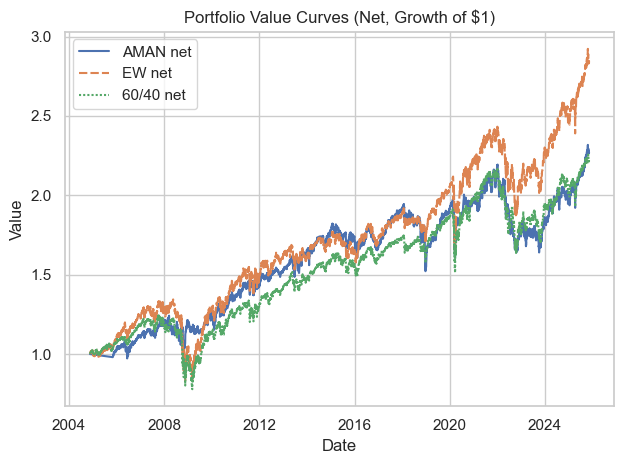

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

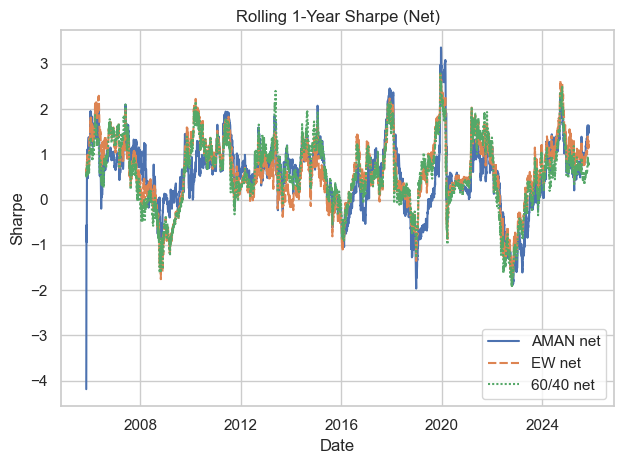

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

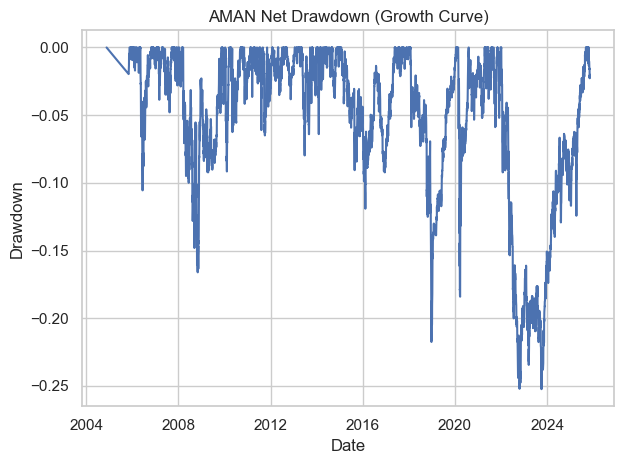

In [102]:
# ==========================================
# PART 7 — Plots with Seaborn (Curves, Risk)
# ==========================================
# Value curves (use NET NAV)
df_plot = pd.DataFrame({
    "AMAN net":   aman_df["AMAN_net_nav"]   / float(aman_df["AMAN_net_nav"].iloc[0]),
    "EW net":     ew_df["EW_net_nav"]       / float(ew_df["EW_net_nav"].iloc[0]),
    "60/40 net":  s6040_df["60_40_net_nav"] / float(s6040_df["60_40_net_nav"].iloc[0]),
})
ax = sns.lineplot(data=df_plot)
ax.set_title("Portfolio Value Curves (Net, Growth of $1)")
ax.set_xlabel("Date"); ax.set_ylabel("Value")
plt.tight_layout(); plt.savefig(FIGS / "curves_net.png", dpi=150)
plt.show()

# Rolling Sharpe (1y) on NET growth curves
TRAD = TRADING_DAYS_PER_YEAR
roll_df = df_plot.pct_change().dropna()
def rolling_sharpe(x):
    s = x.rolling(TRAD).apply(lambda z: (np.sqrt(TRAD) * z.mean() / z.std(ddof=1)) if z.std(ddof=1) > 0 else np.nan, raw=False)
    return s

rs_df = pd.DataFrame({
    "AMAN net":  rolling_sharpe(roll_df["AMAN net"]),
    "EW net":    rolling_sharpe(roll_df["EW net"]),
    "60/40 net": rolling_sharpe(roll_df["60/40 net"]),
}).dropna()

ax = sns.lineplot(data=rs_df)
ax.set_title("Rolling 1-Year Sharpe (Net)")
ax.set_xlabel("Date"); ax.set_ylabel("Sharpe")
plt.tight_layout(); plt.savefig(FIGS / "rolling_sharpe_net.png", dpi=150)
plt.show()

# Drawdowns (AMAN net NAV)
curve = df_plot["AMAN net"]
dd = curve / curve.cummax() - 1.0
ax = sns.lineplot(x=dd.index, y=dd.values)
ax.set_title("AMAN Net Drawdown (Growth Curve)")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
plt.tight_layout(); plt.savefig(FIGS / "drawdowns_aman_net.png", dpi=150)
plt.show()

In [ ]:
# ===============================================================
# PART 8 — Feature Engineering for Predictive Models (SPY)
# ===============================================================

df_spy = pd.DataFrame({
    "r": ret["SPY"],
})
df_spy["lag1"] = df_spy["r"].shift(1)
df_spy["lag2"] = df_spy["r"].shift(2)
df_spy["lag3"] = df_spy["r"].shift(3)
df_spy["ma5"] = df_spy["r"].rolling(5).mean()
df_spy["ma20"] = df_spy["r"].rolling(20).mean()
df_spy["vol20"] = df_spy["r"].rolling(20).std()
df_spy["momentum_20"] = (px["SPY"] / px["SPY"].shift(20)) - 1
df_spy["target"] = (df_spy["r"].shift(-1) > 0).astype(int)
df_spy = df_spy.dropna()
print("SPY features ready:", df_spy.shape)

SPY features ready: (5452, 9)


In [104]:
# ===============================================================
# PART 8b — Feature Engineering for EFA (International Equities)
# ===============================================================
df_efa = pd.DataFrame({
    "r": ret["EFA"],
})
df_efa["lag1"] = df_efa["r"].shift(1)
df_efa["lag2"] = df_efa["r"].shift(2)
df_efa["lag3"] = df_efa["r"].shift(3)
df_efa["ma5"] = df_efa["r"].rolling(5).mean()
df_efa["ma20"] = df_efa["r"].rolling(20).mean()
df_efa["vol20"] = df_efa["r"].rolling(20).std()
df_efa["momentum_20"] = (px["EFA"] / px["EFA"].shift(20)) - 1
df_efa["target"] = (df_efa["r"].shift(-1) > 0).astype(int)
df_efa = df_efa.dropna()
print("EFA features ready:", df_efa.shape)

EFA features ready: (5452, 9)


In [105]:
# ===============================================================
# PART 8c — Feature Engineering for IEF (Treasury Bonds)
# ===============================================================
df_ief = pd.DataFrame({
    "r": ret["IEF"],
})
df_ief["lag1"] = df_ief["r"].shift(1)
df_ief["lag2"] = df_ief["r"].shift(2)
df_ief["lag3"] = df_ief["r"].shift(3)
df_ief["ma5"] = df_ief["r"].rolling(5).mean()
df_ief["ma20"] = df_ief["r"].rolling(20).mean()
df_ief["vol20"] = df_ief["r"].rolling(20).std()
df_ief["momentum_20"] = (px["IEF"] / px["IEF"].shift(20)) - 1
df_ief["target"] = (df_ief["r"].shift(-1) > 0).astype(int)
df_ief = df_ief.dropna()
print("IEF features ready:", df_ief.shape)

IEF features ready: (5452, 9)


In [106]:
# ===============================================================
# PART 8d — Feature Engineering for VNQ (Real Estate)
# ===============================================================
df_vnq = pd.DataFrame({
    "r": ret["VNQ"],
})
df_vnq["lag1"] = df_vnq["r"].shift(1)
df_vnq["lag2"] = df_vnq["r"].shift(2)
df_vnq["lag3"] = df_vnq["r"].shift(3)
df_vnq["ma5"] = df_vnq["r"].rolling(5).mean()
df_vnq["ma20"] = df_vnq["r"].rolling(20).mean()
df_vnq["vol20"] = df_vnq["r"].rolling(20).std()
df_vnq["momentum_20"] = (px["VNQ"] / px["VNQ"].shift(20)) - 1
df_vnq["target"] = (df_vnq["r"].shift(-1) > 0).astype(int)
df_vnq = df_vnq.dropna()
print("VNQ features ready:", df_vnq.shape)

VNQ features ready: (5452, 9)


In [107]:
# ===============================================================
# PART 8e — Feature Engineering for GLD (Gold)
# ===============================================================
df_gld = pd.DataFrame({
    "r": ret["GLD"],
})
df_gld["lag1"] = df_gld["r"].shift(1)
df_gld["lag2"] = df_gld["r"].shift(2)
df_gld["lag3"] = df_gld["r"].shift(3)
df_gld["ma5"] = df_gld["r"].rolling(5).mean()
df_gld["ma20"] = df_gld["r"].rolling(20).mean()
df_gld["vol20"] = df_gld["r"].rolling(20).std()
df_gld["momentum_20"] = (px["GLD"] / px["GLD"].shift(20)) - 1
df_gld["target"] = (df_gld["r"].shift(-1) > 0).astype(int)
df_gld = df_gld.dropna()
print("GLD features ready:", df_gld.shape)

GLD features ready: (5452, 9)


In [108]:
# Combine all engineered datasets for later use
datasets = {
    "SPY": df_spy,
    "EFA": df_efa,
    "IEF": df_ief,
    "VNQ": df_vnq,
    "GLD": df_gld,
}

In [ ]:
# ============================================================
# PART 9 — Train BOTH LSTM (regression) and XGBoost (classification)
#           for EACH asset, then build composite equity signals
# ============================================================
def build_sequences(series: pd.Series, lookback: int = 20):
    """Turn a 1D return series into supervised (X,y) sequences for LSTM."""
    X, y = [], []
    vals = series.values.reshape(-1, 1)
    for i in range(lookback, len(vals)):
        X.append(vals[i - lookback:i, 0])
        y.append(vals[i, 0])
    X = np.array(X)[:, :, None]   # (n, lookback, 1)
    y = np.array(y)
    idx = series.index[lookback:]
    return X, y, idx

def split_by_date(index_like, split_date="2015-01-01"):
    """Return split position using a timestamp threshold."""
    idx_vals = index_like.values if hasattr(index_like, "values") else np.asarray(index_like)
    return np.searchsorted(idx_vals, np.array(np.datetime64(split_date)))

assets = ["SPY", "EFA", "IEF", "VNQ", "GLD"]
equity_assets = ["SPY", "EFA", "VNQ"]

lstm_pred_returns = {}      # per-asset predicted next-day return (continuous)
xgb_pred_class = {}         # per-asset predicted class (0=down, 1=up)
xgb_pred_proba = {}         # per-asset predicted probability for class 1

for sym in assets:
    # -------- LSTM (regression on next-day return) --------
    series = datasets[sym]["r"].copy().dropna()
    lookback = 20
    X_all, y_all, idx_all = build_sequences(series, lookback=lookback)

    if len(idx_all) < 200:
        print(f"[WARN] {sym}: not enough samples for LSTM after lookback; skipping.")
        continue

    split_pos = split_by_date(idx_all, split_date="2015-01-01")
    if split_pos <= lookback or split_pos >= len(idx_all) - 10:
        split_pos = max(lookback + 1, min(len(idx_all) - 10, split_pos))

    X_train, y_train = X_all[:split_pos], y_all[:split_pos]
    X_test,  y_test  = X_all[split_pos:],  y_all[split_pos:]
    idx_train, idx_test = idx_all[:split_pos], idx_all[split_pos:]

    # Scale target only
    scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))
    y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).ravel()

    model = Sequential([
        LSTM(64, input_shape=(lookback, 1), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(
        X_train, y_train_s,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        verbose=0
    )

    y_pred_s = model.predict(X_test, verbose=0).ravel()
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()
    lstm_pred_returns[sym] = pd.Series(y_pred, index=idx_test, name=f"{sym}_lstm_pred")

    # -------- XGBoost (classification of next-day direction) --------
    df_feat = datasets[sym].copy()
    feat_cols = [c for c in df_feat.columns if c not in ["target"]]
    X = df_feat[feat_cols].dropna()
    y = df_feat.loc[X.index, "target"].astype(int)

    split_pos_x = split_by_date(X.index, split_date="2015-01-01")
    split_pos_x = max(50, min(len(X) - 10, split_pos_x))  # guard rails

    X_train_xgb, X_test_xgb = X.iloc[:split_pos_x], X.iloc[split_pos_x:]
    y_train_xgb, y_test_xgb = y.iloc[:split_pos_x], y.iloc[split_pos_x:]

    scaler_X = StandardScaler().fit(X_train_xgb.values)
    X_train_s = scaler_X.transform(X_train_xgb.values)
    X_test_s  = scaler_X.transform(X_test_xgb.values)

    clf = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42
    )
    clf.fit(X_train_s, y_train_xgb)
    y_hat = clf.predict(X_test_s)
    y_proba = clf.predict_proba(X_test_s)[:, 1]

    xgb_pred_class[sym] = pd.Series(y_hat, index=X_test_xgb.index, name=f"{sym}_xgb_cls")
    xgb_pred_proba[sym] = pd.Series(y_proba, index=X_test_xgb.index, name=f"{sym}_xgb_proba")

# ---- Build COMPOSITE signals for overlays (equity sleeve only) ----
# LSTM composite = mean predicted next-day return across equities; sign -> overlay
lstm_equity_pred = pd.concat([lstm_pred_returns[s] for s in equity_assets], axis=1).mean(axis=1)
lstm_equity_pred = lstm_equity_pred.asfreq("B").ffill()
lstm_df = pd.DataFrame({"y_pred": lstm_equity_pred})  

# XGBoost composite = majority vote across equities (bearish=0, bullish=1)
xgb_equity_vote = pd.concat([xgb_pred_class[s] for s in equity_assets], axis=1)
xgb_equity_vote = (xgb_equity_vote.mean(axis=1) >= 0.5).astype(int)
xgb_equity_vote = xgb_equity_vote.asfreq("B").ffill()
pred_series = xgb_equity_vote  

In [ ]:
# ============================================================
# PART 9b — Per-Asset Diagnostics, Feature Importance, Exports
# ============================================================
import os, pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

try:
    FIGS
except NameError:
    ROOT = Path(".").resolve()
    FIGS = ROOT / "reports" / "figures"
    TABLES = ROOT / "reports" / "tables"
    for d in (FIGS, TABLES):
        d.mkdir(parents=True, exist_ok=True)

try:
    MODELS
except NameError:
    MODELS = Path("./models").resolve()
MODELS.mkdir(parents=True, exist_ok=True)

# Expect these dicts from Part 9; guard if missing
assert 'datasets' in globals(), "datasets not found. Run Parts 8/8b–8e first."
assets = list(datasets.keys())

# These may exist from Part 9; if so we'll export them; otherwise we’ll still compute diagnostics
lstm_pred_returns  = globals().get("lstm_pred_returns",  {})
xgb_pred_class     = globals().get("xgb_pred_class",     {})
xgb_pred_proba     = globals().get("xgb_pred_proba",     {})

diag_rows = []

for sym in assets:
    # Build feature matrix and target
    df_feat = datasets[sym].copy()
    if "target" not in df_feat.columns:
        raise ValueError(f"{sym}: 'target' column missing. Re-run Part 8 for {sym}.")
    feat_cols = [c for c in df_feat.columns if c != "target"]
    X = df_feat[feat_cols].dropna()
    y = df_feat.loc[X.index, "target"].astype(int)

    # Time-based split
    split_date = np.datetime64("2015-01-01")
    idx_vals = X.index.values
    split_pos = np.searchsorted(idx_vals, split_date)
    split_pos = max(50, min(len(X) - 10, split_pos))  # guard rails

    X_train, X_test = X.iloc[:split_pos], X.iloc[split_pos:]
    y_train, y_test = y.iloc[:split_pos], y.iloc[split_pos:]

    # Scale features and fit XGB
    scaler_X = StandardScaler().fit(X_train.values)
    X_train_s = scaler_X.transform(X_train.values)
    X_test_s  = scaler_X.transform(X_test.values)

    clf = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="logloss",
        random_state=42
    )
    clf.fit(X_train_s, y_train)
    y_hat = clf.predict(X_test_s)

    # Accuracy & confusion matrix
    acc = accuracy_score(y_test, y_hat)
    cm  = confusion_matrix(y_test, y_hat)
    diag_rows.append(pd.Series({"asset": sym, "xgb_accuracy": acc}))

    # Plot & save confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"{sym} — XGBoost Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(FIGS / f"{sym}_xgb_confusion.png", dpi=150)
    plt.close()

    # Save classification report
    with open(TABLES / f"{sym}_xgb_classification_report.txt", "w") as f:
        f.write(classification_report(y_test, y_hat))

    # Export predictions from Part 9 if available
    if sym in xgb_pred_class:
        xgb_pred_class[sym].to_csv(TABLES / f"{sym}_xgb_pred_class.csv")
    if sym in xgb_pred_proba:
        xgb_pred_proba[sym].to_csv(TABLES / f"{sym}_xgb_pred_proba.csv")
    if sym in lstm_pred_returns:
        lstm_pred_returns[sym].to_csv(TABLES / f"{sym}_lstm_pred_returns.csv")

    # Persist scaler and model
    with open(MODELS / f"{sym}_xgb_scaler.pkl", "wb") as f:
        pickle.dump(scaler_X, f)
    with open(MODELS / f"{sym}_xgb_model.pkl", "wb") as f:
        pickle.dump(clf, f)

    # Feature importance (gain)
    try:
        importances = clf.get_booster().get_score(importance_type="gain")
        imp_df = pd.DataFrame({"feature": list(importances.keys()),
                               "gain": list(importances.values())}).sort_values("gain", ascending=False)
        plt.figure(figsize=(6, 4))
        sns.barplot(data=imp_df.head(10), x="gain", y="feature")
        plt.title(f"{sym} — XGBoost Top Feature Importance (gain)")
        plt.tight_layout()
        plt.savefig(FIGS / f"{sym}_xgb_feature_importance.png", dpi=150)
        plt.close()
        imp_df.to_csv(TABLES / f"{sym}_xgb_feature_importance.csv", index=False)
    except Exception:
        pass

# Summary CSV
diag_df = pd.DataFrame(diag_rows).set_index("asset")
diag_df.to_csv(TABLES / "xgb_diagnostics_summary.csv")
diag_df

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

,xgb_accuracy
asset,
SPY,0.522246
EFA,0.519421
IEF,0.506003
VNQ,0.495410
GLD,0.498941


/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

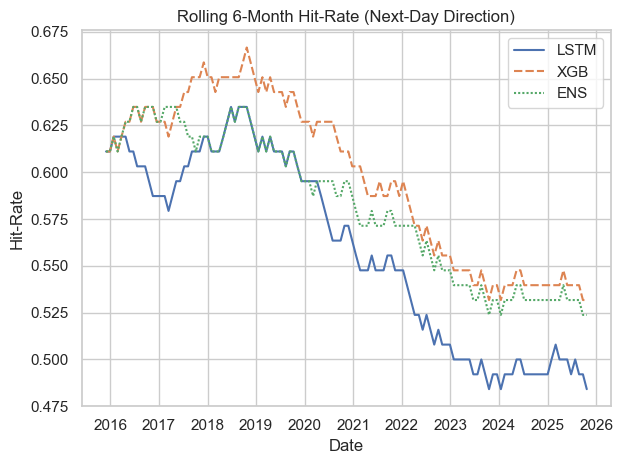

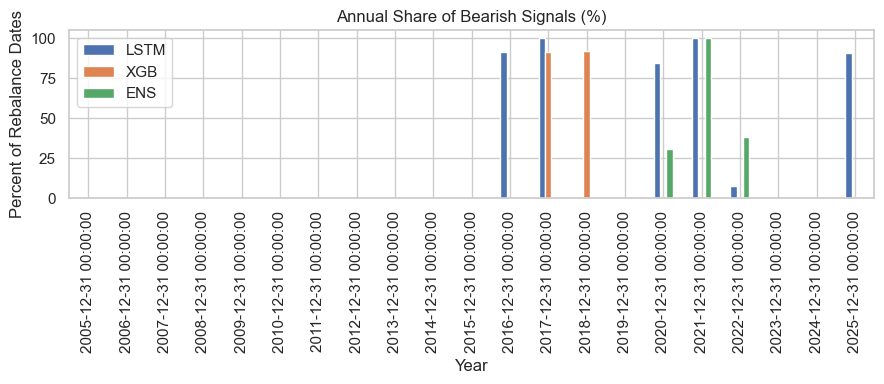

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

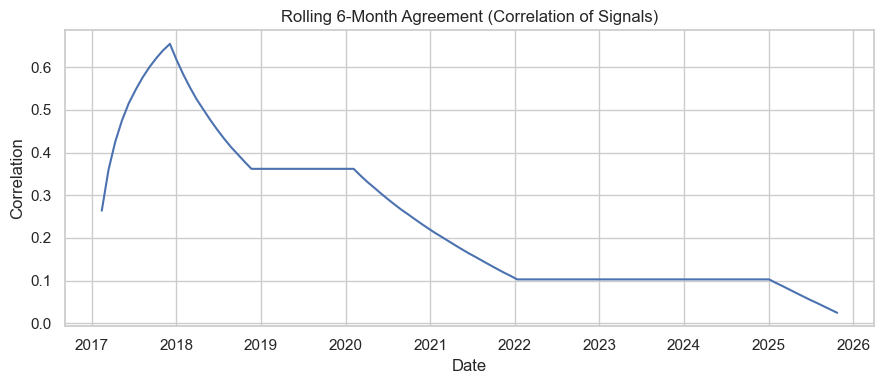

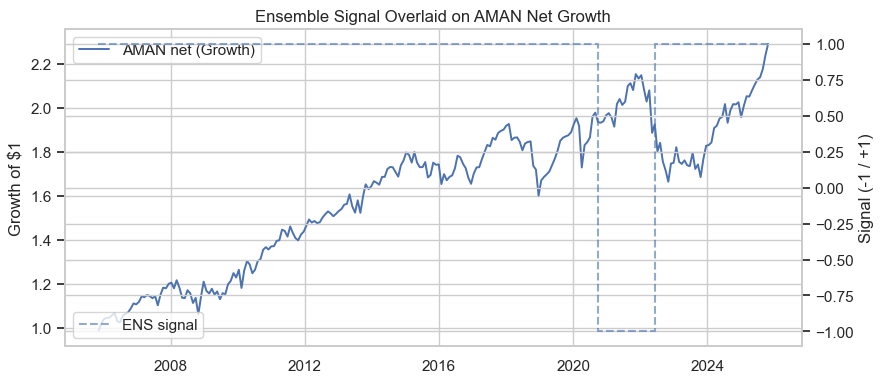

In [ ]:
# ============================================================
# PART 9c — Smoothed overlay signals + useful charts
#   - Probability-threshold XGB signal (uses per-asset probs)
#   - Confirmation & minimum-hold filters to reduce flip-flops
#   - Rolling hit-rate, annual bearish share, agreement heatmap
#   - Signals plotted over AMAN value curve 
# ============================================================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- 1) Build raw composite signals ----------
# LSTM: use mean predicted next-day return across equities
lstm_raw = pd.concat([lstm_pred_returns[s] for s in ["SPY","EFA","VNQ"]], axis=1).mean(axis=1)
lstm_raw = lstm_raw.asfreq("B").ffill()
lstm_sign = lstm_raw.reindex(weights_df.index, method="ffill").fillna(0.0).apply(lambda x: -1 if x < 0 else 1)

# XGB: use probability-based vote (more stable than hard classes)
assert all(s in xgb_pred_proba for s in ["SPY","EFA","VNQ"]), "Run Part 9 to populate xgb_pred_proba."
xgb_proba = pd.concat([xgb_pred_proba[s] for s in ["SPY","EFA","VNQ"]], axis=1).mean(axis=1)
# proba is P(up); bearish if P(up) < 0.45 (tunable)
xgb_raw = xgb_proba.asfreq("B").ffill()
xgb_sign = xgb_raw.reindex(weights_df.index, method="ffill").fillna(0.5).apply(lambda p: -1 if p < 0.45 else 1)

# Ensemble: mean of signs
ens_sign = ((lstm_sign + xgb_sign) / 2.0).apply(lambda z: -1 if z < 0 else 1)

# ---------- 2) Debounce / smooth signals ----------
def smooth_sign(sig: pd.Series, confirm=2, min_hold=21) -> pd.Series:
    """
    confirm: require this many consecutive opposite signals to flip
    min_hold: minimum bars to hold current state
    """
    sig = sig.astype(int).copy()
    out = sig.copy()
    state = sig.iloc[0]
    hold = 0
    streak = 0
    for i in range(1, len(sig)):
        hold += 1
        if sig.iloc[i] == state:
            streak = 0
            out.iloc[i] = state
            continue
        # signal differs from state
        streak += 1
        if hold >= min_hold and streak >= confirm:
            state = sig.iloc[i]
            hold = 0
            streak = 0
        out.iloc[i] = state
    return out

lstm_sm = smooth_sign(lstm_sign, confirm=2, min_hold=REBALANCE_DAYS)
xgb_sm  = smooth_sign(xgb_sign,  confirm=3, min_hold=REBALANCE_DAYS)  # stricter for tree noise
ens_sm  = smooth_sign(ens_sign,  confirm=2, min_hold=REBALANCE_DAYS)

# Save overlay-ready series for later parts 
lstm_sm.rename("lstm_signal").to_csv(TABLES / "overlay_signal_lstm.csv")
xgb_sm.rename("xgb_signal").to_csv(TABLES / "overlay_signal_xgb.csv")
ens_sm.rename("ensemble_signal").to_csv(TABLES / "overlay_signal_ensemble.csv")

# ---------- 3) Rolling hit-rate (6 months) ----------
def rolling_hit_rate(sig: pd.Series, next_ret: pd.Series, window=126) -> pd.Series:
    s = pd.concat([sig, next_ret], axis=1).dropna()
    s.columns = ["sig","ret"]
    hr = (np.sign(s["sig"]) == np.sign(s["ret"])).astype(int).rolling(window).mean()
    return hr.reindex(sig.index, method="nearest")

spy_next = ret["SPY"].shift(-1)
hr_lstm = rolling_hit_rate(lstm_sm, spy_next)
hr_xgb  = rolling_hit_rate(xgb_sm,  spy_next)
hr_ens  = rolling_hit_rate(ens_sm,  spy_next)

hr_df = pd.DataFrame({"LSTM": hr_lstm, "XGB": hr_xgb, "ENS": hr_ens}).dropna()
ax = sns.lineplot(data=hr_df)
ax.set_title("Rolling 6-Month Hit-Rate (Next-Day Direction)")
ax.set_xlabel("Date"); ax.set_ylabel("Hit-Rate")
plt.tight_layout(); plt.savefig(FIGS / "overlay_hit_rate_6m.png", dpi=150)
plt.show()

# ---------- 4) Annual bearish frequency ----------
annual = pd.DataFrame({
    "LSTM": (lstm_sm == -1).astype(int),
    "XGB":  (xgb_sm == -1).astype(int),
    "ENS":  (ens_sm == -1).astype(int),
}).groupby(pd.Grouper(freq="Y")).mean()

ax = annual.mul(100).plot(kind="bar", figsize=(9,4))
plt.title("Annual Share of Bearish Signals (%)")
plt.xlabel("Year"); plt.ylabel("Percent of Rebalance Dates")
plt.tight_layout(); plt.savefig(FIGS / "overlay_bearish_share_by_year.png", dpi=150)
plt.show()

# ---------- 5) Agreement between models (rolling correlation of signs) ----------
agree = pd.concat([lstm_sm, xgb_sm], axis=1)
agree.columns = ["LSTM", "XGB"]

# Convert {-1,+1} to {0,1} for stable correlation
agree01 = agree.replace(-1, 0)

# Compute rolling correlation between LSTM and XGB columns directly
rolling_corr = (
    agree01["LSTM"]
    .rolling(126)
    .corr(agree01["XGB"])
    .dropna()
)

plt.figure(figsize=(9,4))
sns.lineplot(x=rolling_corr.index, y=rolling_corr.values)
plt.title("Rolling 6-Month Agreement (Correlation of Signals)")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.tight_layout()
plt.savefig(FIGS / "overlay_agreement_corr.png", dpi=150)
plt.show()

# ---------- 6) Context plot: signals over portfolio curve ----------
aman_growth = aman_df["AMAN_net_nav"] / float(aman_df["AMAN_net_nav"].iloc[0])
sig_plot = pd.DataFrame({"AMAN": aman_growth, "ENS": ens_sm}).dropna()
fig, ax1 = plt.subplots(figsize=(9,4))
ax1.plot(sig_plot.index, sig_plot["AMAN"], label="AMAN net (Growth)", linewidth=1.4)
ax1.set_ylabel("Growth of $1")
ax2 = ax1.twinx()
ax2.step(sig_plot.index, sig_plot["ENS"], where="post", linestyle="--", alpha=0.6, label="ENS signal")
ax2.set_ylabel("Signal (-1 / +1)")
ax1.set_title("Ensemble Signal Overlaid on AMAN Net Growth")
ax1.legend(loc="upper left"); ax2.legend(loc="lower left")
plt.tight_layout(); plt.savefig(FIGS / "overlay_signal_vs_growth.png", dpi=150)
plt.show()

# ---------- 7) Export for downstream overlays ----------
# If you still want to run Parts 10–12 with smoothed signals:
lstm_sig = lstm_sm.copy()
xgb_sig  = xgb_sm.copy()
ens_sig  = ens_sm.copy()

In [112]:
# ===============================================================
# PART 9c — Apply XGBoost Signal Overlay to AMAN Portfolio
# ===============================================================

# Convert test predictions into time series aligned with test data
pred_series = pd.Series(y_pred, index=X_test.index)
pred_series.name = "xgb_signal"

# Convert signal into overlay-friendly format: +1 = bullish, 0 = bearish
signal_overlay = pred_series.reindex(weights_df.index, method="ffill").fillna(1)

def apply_xgb_overlay(base_weights: pd.DataFrame,
                      signals: pd.Series,
                      equity_tickers=("SPY","EFA","VNQ"),
                      defensive_tickers=("IEF","GLD"),
                      cut=0.50):
    w = base_weights.copy()
    sig = signals.reindex(w.index, method="ffill").fillna(1)
    for dt in w.index:
        if sig.loc[dt] == 0:  # bearish, reduce equities
            eq_w = w.loc[dt, list(equity_tickers)].sum()
            shift_amt = eq_w * cut
            w.loc[dt, list(equity_tickers)] *= (1.0 - cut)
            def_w = w.loc[dt, list(defensive_tickers)].copy()
            if def_w.sum() <= 0:
                for t in defensive_tickers:
                    w.loc[dt, t] += shift_amt / len(defensive_tickers)
            else:
                share = def_w / def_w.sum()
                for t in defensive_tickers:
                    w.loc[dt, t] += shift_amt * share[t]
        total = w.loc[dt].sum()
        if total > 0:
            w.loc[dt] = w.loc[dt] / total
    return w

weights_xgb = apply_xgb_overlay(weights_df.copy(), signal_overlay)
weights_xgb.tail()

Ticker,SPY,EFA,IEF,VNQ,GLD
2025-06-27,0.117151,0.151772,0.406531,0.160356,0.164190
2025-07-28,0.123276,0.166935,0.404404,0.164969,0.140416
2025-08-26,0.384814,0.375749,0.000000,0.000000,0.239437
2025-09-24,0.239077,0.186553,0.400821,0.000000,0.173550
2025-10-23,0.246843,0.185586,0.401697,0.000000,0.165874


In [113]:
# ==================================================================
# PART 10 — Risk Overlays: LSTM, XGBoost, and Ensemble
# ==================================================================
def apply_risk_overlay(base_weights: pd.DataFrame,
                       signal: pd.Series,
                       equity_tickers=("SPY","EFA","VNQ"),
                       defensive_tickers=("IEF","GLD"),
                       cut=0.50) -> pd.DataFrame:
    """
    If signal < 0 (bearish), reduce equity sleeve by `cut` and shift to defensive.
    If signal >= 0 (bullish/neutral), keep base weights.
    Signal is aligned to weight index via ffill.
    """
    w = base_weights.copy()
    sig = signal.reindex(w.index, method="ffill").ffill()

    for dt in w.index:
        if sig.loc[dt] < 0:
            eq_w = w.loc[dt, list(equity_tickers)].sum()
            shift_amt = eq_w * cut
            # Reduce equities proportionally
            w.loc[dt, list(equity_tickers)] *= (1.0 - cut)
            # Allocate to defensive in proportion to current defensive weights
            def_w = w.loc[dt, list(defensive_tickers)].copy()
            if def_w.sum() <= 0:
                for t in defensive_tickers:
                    w.loc[dt, t] += shift_amt / len(defensive_tickers)
            else:
                share = def_w / def_w.sum()
                for t in defensive_tickers:
                    w.loc[dt, t] += shift_amt * share[t]
        # Re-normalize
        total = w.loc[dt].sum()
        if total > 0:
            w.loc[dt] = w.loc[dt] / total
    return w

# Apply overlays
weights_lstm      = apply_risk_overlay(weights_df, lstm_sig, cut=0.50)
weights_xgb       = apply_risk_overlay(weights_df, xgb_sig,  cut=0.50)
weights_ensemble  = apply_risk_overlay(weights_df, ens_sig,  cut=0.50)

weights_lstm.tail(), weights_xgb.tail(), weights_ensemble.tail()

(Ticker           SPY       EFA       IEF       VNQ       GLD
 2025-06-27  0.058576  0.075886  0.559422  0.080178  0.225939
 2025-07-28  0.061638  0.083468  0.573337  0.082485  0.199073
 2025-08-26  0.192407  0.187875  0.000000  0.000000  0.619719
 2025-09-24  0.119538  0.093276  0.549332  0.000000  0.237853
 2025-10-23  0.123422  0.092793  0.554723  0.000000  0.229063,
 Ticker           SPY       EFA       IEF       VNQ       GLD
 2025-06-27  0.117151  0.151772  0.406531  0.160356  0.164190
 2025-07-28  0.123276  0.166935  0.404404  0.164969  0.140416
 2025-08-26  0.384814  0.375749  0.000000  0.000000  0.239437
 2025-09-24  0.239077  0.186553  0.400821  0.000000  0.173550
 2025-10-23  0.246843  0.185586  0.401697  0.000000  0.165874,
 Ticker           SPY       EFA       IEF       VNQ       GLD
 2025-06-27  0.117151  0.151772  0.406531  0.160356  0.164190
 2025-07-28  0.123276  0.166935  0.404404  0.164969  0.140416
 2025-08-26  0.384814  0.375749  0.000000  0.000000  0.239437
 2025-

In [114]:
# ======================================================
# PART 11 — Backtests (With Fees): LSTM, XGBoost, Ensemble
# ======================================================
# AMAN + LSTM
aman_lstm_df = backtest_dynamic_fees(
    weights_df=weights_lstm, ret=ret,
    aum_start=AUM_START, startup_cost=STARTUP_COST,
    mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
    tc_per_turnover=TC_PER_TURNOVER, name="AMAN_LSTM"
)

# AMAN + XGBoost
aman_xgb_df = backtest_dynamic_fees(
    weights_df=weights_xgb, ret=ret,
    aum_start=AUM_START, startup_cost=STARTUP_COST,
    mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
    tc_per_turnover=TC_PER_TURNOVER, name="AMAN_XGB"
)

# AMAN + Ensemble(LSTM+XGB)
aman_ens_df = backtest_dynamic_fees(
    weights_df=weights_ensemble, ret=ret,
    aum_start=AUM_START, startup_cost=STARTUP_COST,
    mgmt_fee_daily=MGMT_FEE_DAILY, perf_fee_rate=PERF_FEE_RATE,
    tc_per_turnover=TC_PER_TURNOVER, name="AMAN_ENS"
)

# Create standardized growth curves (net NAV normalized to 1 at start)
def to_growth(nav_series: pd.Series) -> pd.Series:
    return nav_series / float(nav_series.iloc[0])

cmp_net_growth = pd.DataFrame({
    "AMAN net":          to_growth(aman_df["AMAN_net_nav"]),
    "AMAN LSTM net":     to_growth(aman_lstm_df["AMAN_LSTM_net_nav"]),
    "AMAN XGB net":      to_growth(aman_xgb_df["AMAN_XGB_net_nav"]),
    "AMAN ENS net":      to_growth(aman_ens_df["AMAN_ENS_net_nav"]),
    "EW net":            to_growth(ew_df["EW_net_nav"]),
    "60/40 net":         to_growth(s6040_df["60_40_net_nav"]),
}).dropna()

# Summary table for quick comparison
summary_ai = pd.DataFrame({
    "AMAN_net":       summarize_curve(cmp_net_growth["AMAN net"]),
    "AMAN_LSTM_net":  summarize_curve(cmp_net_growth["AMAN LSTM net"]),
    "AMAN_XGB_net":   summarize_curve(cmp_net_growth["AMAN XGB net"]),
    "AMAN_ENS_net":   summarize_curve(cmp_net_growth["AMAN ENS net"]),
    "EW_net":         summarize_curve(cmp_net_growth["EW net"]),
    "60_40_net":      summarize_curve(cmp_net_growth["60/40 net"]),
}).T

summary_ai.to_csv(TABLES / "summary_overlay_ai.csv")
summary_ai

,ann_return,ann_vol,sharpe,max_drawdown,terminal_value
AMAN_net,0.043840,0.101098,0.424440,-0.252438,2.271233
AMAN_LSTM_net,0.040619,0.096159,0.414094,-0.235495,2.146602
AMAN_XGB_net,0.043518,0.099125,0.429775,-0.252438,2.265826
AMAN_ENS_net,0.041869,0.099061,0.414086,-0.217576,2.189638
EW_net,0.058296,0.129938,0.436108,-0.380060,2.848008
60_40_net,0.044997,0.120153,0.366348,-0.374658,2.222646


/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

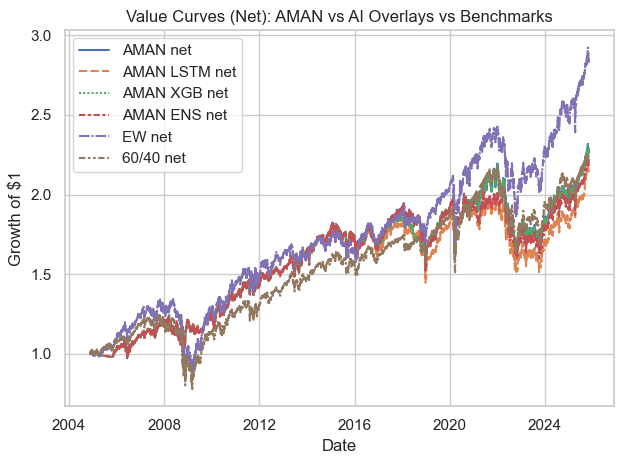

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) inst

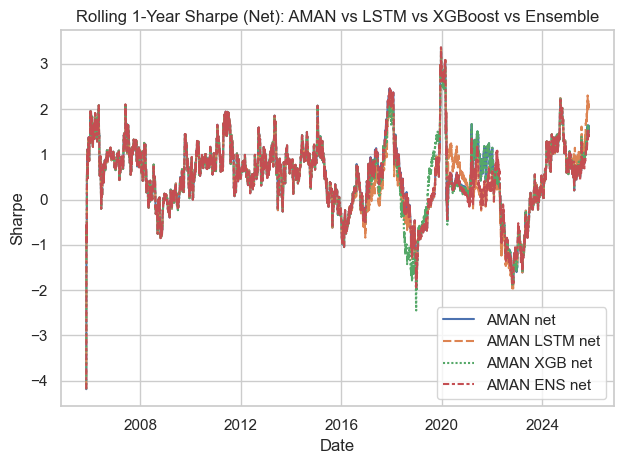

/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jck/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

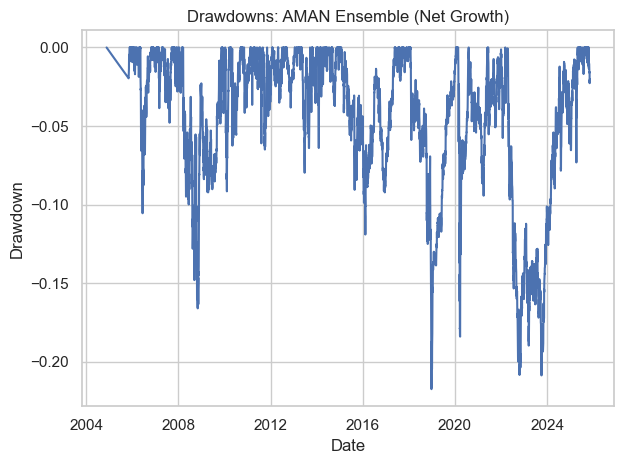

In [115]:
# ============================================
# PART 12 — Plots (Seaborn): Curves & Sharpe
# ============================================
# 1) Value curves (Net)
ax = sns.lineplot(data=cmp_net_growth[["AMAN net","AMAN LSTM net","AMAN XGB net","AMAN ENS net","EW net","60/40 net"]])
ax.set_title("Value Curves (Net): AMAN vs AI Overlays vs Benchmarks")
ax.set_xlabel("Date"); ax.set_ylabel("Growth of $1")
plt.tight_layout(); plt.savefig(FIGS / "curves_overlay_ai_net.png", dpi=150)
plt.show()

# 2) Rolling 1-year Sharpe (Net) for AMAN variants only
def rolling_sharpe(series: pd.Series, window: int = TRADING_DAYS_PER_YEAR) -> pd.Series:
    return (series.pct_change()
            .rolling(window)
            .apply(lambda x: np.sqrt(TRADING_DAYS_PER_YEAR) * x.mean() / x.std(ddof=1) if x.std(ddof=1) > 0 else np.nan))

rs_ai = pd.DataFrame({
    "AMAN net":         rolling_sharpe(cmp_net_growth["AMAN net"]),
    "AMAN LSTM net":    rolling_sharpe(cmp_net_growth["AMAN LSTM net"]),
    "AMAN XGB net":     rolling_sharpe(cmp_net_growth["AMAN XGB net"]),
    "AMAN ENS net":     rolling_sharpe(cmp_net_growth["AMAN ENS net"]),
}).dropna()

ax = sns.lineplot(data=rs_ai)
ax.set_title("Rolling 1-Year Sharpe (Net): AMAN vs LSTM vs XGBoost vs Ensemble")
ax.set_xlabel("Date"); ax.set_ylabel("Sharpe")
plt.tight_layout(); plt.savefig(FIGS / "rolling_sharpe_overlay_ai_net.png", dpi=150)
plt.show()

# 3) Drawdowns for the Ensemble variant
ens_curve = cmp_net_growth["AMAN ENS net"]
dd_ens = ens_curve / ens_curve.cummax() - 1.0
ax = sns.lineplot(x=dd_ens.index, y=dd_ens.values)
ax.set_title("Drawdowns: AMAN Ensemble (Net Growth)")
ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
plt.tight_layout(); plt.savefig(FIGS / "drawdowns_aman_ensemble_net.png", dpi=150)
plt.show()

In [116]:
# =======================================
# PART 13 — Export Artifacts & Final Logs
# =======================================
# 1) Consolidate summaries into one master table
def _safe_read_csv(path):
    try:
        return pd.read_csv(path, index_col=0)
    except Exception:
        return None

summary_core_nav = _safe_read_csv(TABLES / "summary_core_nav.csv")
summary_nav      = _safe_read_csv(TABLES / "summary_nav.csv")
summary_overlay  = _safe_read_csv(TABLES / "summary_overlay_nav.csv")
summary_ai       = _safe_read_csv(TABLES / "summary_overlay_ai.csv")

summary_frames = []
for df in [summary_core_nav, summary_nav, summary_overlay, summary_ai]:
    if df is not None:
        summary_frames.append(df)

master_summary = None
if summary_frames:
    master_summary = pd.concat(summary_frames, axis=0)
    master_summary = master_summary[~master_summary.index.duplicated(keep="last")]
    master_summary.to_csv(TABLES / "master_summary.csv")

# 2) Save normalized growth curves for all strategies we produced
curves = {}
def _add_curve(name, series):
    if series is not None and len(series) > 0:
        curves[name] = series / float(series.iloc[0])

_add_curve("AMAN_net",        aman_df["AMAN_net_nav"])
_add_curve("AMAN_LSTM_net",   aman_lstm_df["AMAN_LSTM_net_nav"] if "aman_lstm_df" in globals() else None)
_add_curve("AMAN_XGB_net",    aman_xgb_df["AMAN_XGB_net_nav"] if "aman_xgb_df" in globals() else None)
_add_curve("AMAN_ENS_net",    aman_ens_df["AMAN_ENS_net_nav"] if "aman_ens_df" in globals() else None)
_add_curve("EW_net",          ew_df["EW_net_nav"])
_add_curve("60_40_net",       s6040_df["60_40_net_nav"])

curves_df = pd.DataFrame(curves).dropna(how="all")
curves_df.to_csv(TABLES / "all_value_curves_net.csv")
curves_df.tail().to_csv(TABLES / "all_value_curves_tail_net.csv")

# 3) Management-ready KPI snapshot (from NET NAV)
def _kpi(series):
    if series is None or series.empty:
        return pd.Series(dtype=float)
    growth = series / float(series.iloc[0])
    dr = growth.pct_change().dropna()
    ann_ret = (1 + dr.mean())**TRADING_DAYS_PER_YEAR - 1
    ann_vol = dr.std(ddof=1) * np.sqrt(TRADING_DAYS_PER_YEAR)
    sharpe  = (np.sqrt(TRADING_DAYS_PER_YEAR) * dr.mean() / dr.std(ddof=1)) if dr.std(ddof=1) > 0 else np.nan
    mdd     = float((growth / growth.cummax() - 1).min())
    return pd.Series({
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": mdd,
        "terminal_value": float(growth.iloc[-1])
    })

kpi_rows = []
for name, series in {
    "AMAN_net":        aman_df["AMAN_net_nav"],
    "AMAN_LSTM_net":   aman_lstm_df["AMAN_LSTM_net_nav"] if "aman_lstm_df" in globals() else None,
    "AMAN_XGB_net":    aman_xgb_df["AMAN_XGB_net_nav"] if "aman_xgb_df" in globals() else None,
    "AMAN_ENS_net":    aman_ens_df["AMAN_ENS_net_nav"] if "aman_ens_df" in globals() else None,
    "EW_net":          ew_df["EW_net_nav"],
    "60_40_net":       s6040_df["60_40_net_nav"],
}.items():
    if series is not None:
        k = _kpi(series)
        k.name = name
        kpi_rows.append(k)

kpi_df = pd.DataFrame(kpi_rows)
kpi_df.to_csv(TABLES / "management_kpis_net.csv")

# 4) Save a configuration + metadata JSON for reproducibility
config = {
    "universe": TICKERS,
    "start": START,
    "end": END,
    "rebalance_days": REBALANCE_DAYS,
    "momentum_lookback_days": MOM_LOOKBACK_DAYS,
    "vol_lookback_days": VOL_LOOKBACK_DAYS,
    "cap_per_asset": CAP_PER_ASSET,
    "transaction_cost_per_turnover": TC_PER_TURNOVER,
    "fees": {
        "startup_cost": STARTUP_COST,
        "aum_start": float(AUM_START),
        "mgmt_fee_annual": MGMT_FEE_ANNUAL,
        "mgmt_fee_daily": float(MGMT_FEE_DAILY),
        "performance_fee_rate": PERF_FEE_RATE
    },
    "models": {
        "lstm": {"lookback": 20, "epochs": 100, "dropout": 0.3, "units": 64},
        "xgboost": {"n_estimators": 200, "max_depth": 4, "learning_rate": 0.05,
                    "subsample": 0.9, "colsample_bytree": 0.9}
    },
    "overlays": {"cut_equity_fraction": 0.50, "ensemble_logic": "mean_sign_threshold_0"}
}
with open(TABLES / "run_config.json", "w") as f:
    json.dump(config, f, indent=2)

# 5) Create a brief text summary for the appendix
summary_lines = []
summary_lines.append("Aurora Multi-Asset Navigator (AMAN) — Final Export Summary\n")
summary_lines.append(f"Universe: {', '.join(TICKERS)}")
summary_lines.append(f"Period: {START} to {str(END)}")
summary_lines.append(f"Fees: 2% mgmt annual, 20% performance (HWM), startup ${STARTUP_COST:,.0f}, TC {TC_PER_TURNOVER*1e4:.1f} bps/100% turnover")
summary_lines.append("Overlays: LSTM, XGBoost, and Ensemble (bearish if mean < 0)")
summary_lines.append("\nKey KPIs (Net Growth Curves):\n")
summary_lines.append(kpi_df.to_string(float_format=lambda x: f"{x:,.4f}"))
summary_lines.append("\nFiles written:")
written = [
    "master_summary.csv" if master_summary is not None else None,
    "all_value_curves_net.csv",
    "all_value_curves_tail_net.csv",
    "management_kpis_net.csv",
    "run_config.json"
]
summary_lines.extend([f"- {w}" for w in written if w is not None])

with open(TABLES / "APPENDIX_EXPORT_NOTES.txt", "w") as f:
    f.write("\n".join(summary_lines))

print("Saved artifacts in:", TABLES)
print(" - master_summary.csv (if available merge)")
print(" - all_value_curves_net.csv")
print(" - all_value_curves_tail_net.csv")
print(" - management_kpis_net.csv")
print(" - run_config.json")
print(" - APPENDIX_EXPORT_NOTES.txt")

Saved artifacts in: /Users/jck/Documents/MSDS/MSDS 451 2025/term project/Final term project /reports/tables
 - master_summary.csv (if available merge)
 - all_value_curves_net.csv
 - all_value_curves_tail_net.csv
 - management_kpis_net.csv
 - run_config.json
 - APPENDIX_EXPORT_NOTES.txt


In [118]:
!jupyter nbconvert --to pdf MSDS451_Final_term_project.ipynb

[NbConvertApp] Converting notebook MSDS451_Final_term_project.ipynb to pdf
[NbConvertApp] Support files will be in MSDS451_Final_term_project_files/
[NbConvertApp] Making directory ./MSDS451_Final_term_project_files
[NbConvertApp] Writing 217569 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 663187 bytes to MSDS451_Final_term_project.pdf
